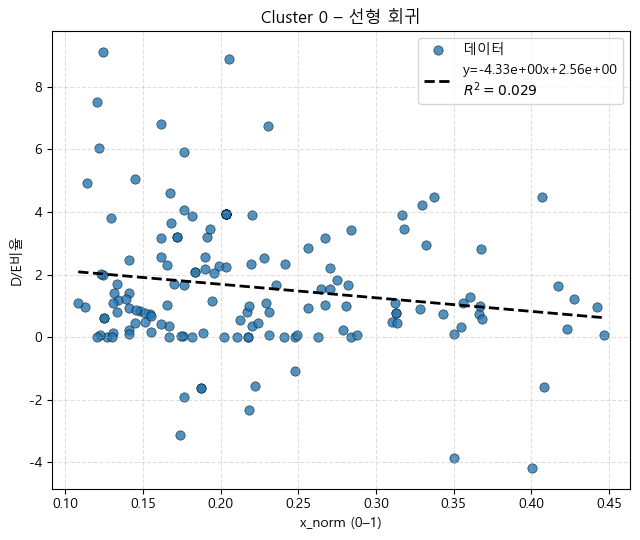

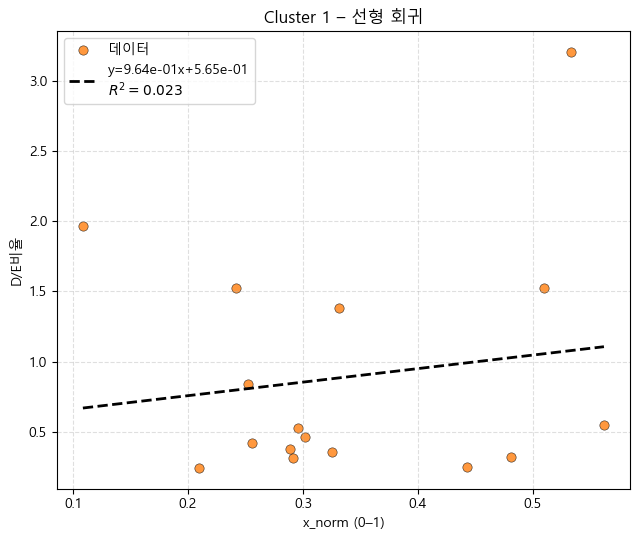

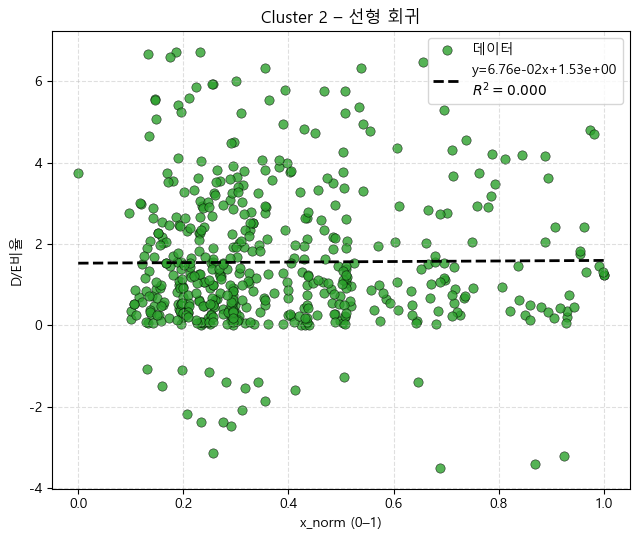

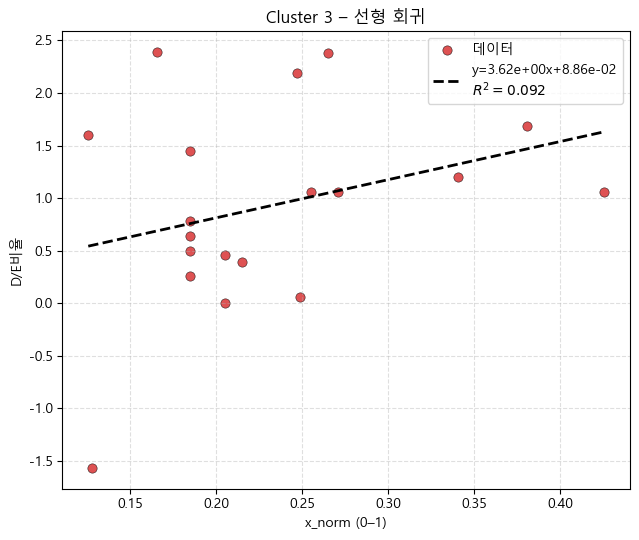

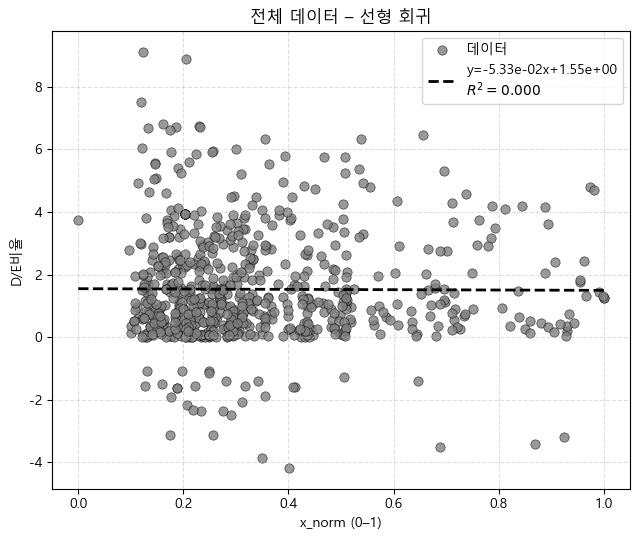

In [14]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
import matplotlib.font_manager as fm, platform, pathlib
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler

# ─────────── 0. 한글 글꼴 ───────────
def set_kfont():
    if platform.system() == "Darwin":
        plt.rc("font", family="AppleGothic")
    elif platform.system() == "Windows":
        fm.fontManager.addfont(r"../GmarketSansTTFMedium.ttf")
        plt.rc("font", family="Malgun Gothic")
    else:
        fm.fontManager.addfont("../GmarketSansTTFMedium.ttf")
        plt.rc("font", family="NanumGothic")
    plt.rcParams["axes.unicode_minus"] = False
set_kfont()

# ─────────── 1. 데이터 로드 ───────────
file = '입주공장_면적x평당매매가추가_output.xlsx'
df   = pd.read_excel(file)

x_col, y_col = "면적 * 평당매매가", "D/E비율"     # 원본 열 이름
df[[x_col, y_col]] = df[[x_col, y_col]].apply(pd.to_numeric, errors='coerce')
df = df.dropna(subset=[x_col, y_col, "cluster"]).copy()

# ─────────── 2. IQR 이상치 제거 ───────
def rm_iqr(d, x, y, g):
    keep = pd.Series(True, index=d.index)
    for c in d[g].unique():
        p = d[d[g] == c]
        for col in (x, y):
            q1, q3 = p[col].quantile([.25, .75]); iqr = q3 - q1
            lo, hi = q1 - 1.5*iqr, q3 + 1.5*iqr
            keep &= ~((d[g]==c) & ((d[col] < lo) | (d[col] > hi)))
    return d[keep]
df = rm_iqr(df, x_col, y_col, "cluster")

# ─────────── 3. x 값 Min-Max 정규화 ──
scaler = MinMaxScaler()
df["x_norm"] = scaler.fit_transform(df[[x_col]])
df["y"]      = df[y_col]           # 이름 짧게

# ─────────── 4. 선형 회귀 + 그래프 ──
palette = {0:"tab:blue",1:"tab:orange",2:"tab:green",3:"tab:red"}
out_dir = pathlib.Path("cluster_plots_linear")
out_dir.mkdir(exist_ok=True)

def plot_linear(sub, title, color, fname):
    X = sub[["x_norm"]].values
    y = sub[["y"]].values
    lr = LinearRegression().fit(X, y)
    a, b = lr.coef_.item(), lr.intercept_.item()
    r2   = lr.score(X, y)

    xs = np.linspace(X.min(), X.max(), 300).reshape(-1,1)
    ys = lr.predict(xs)

    fig, ax = plt.subplots(figsize=(6.5, 5.5))
    ax.scatter(X, y, color=color, alpha=.8, s=45,
               edgecolors='k', linewidths=.4, label="데이터")
    ax.plot(xs, ys, 'k--', lw=2,
            label=f"y={a:.2e}x+{b:.2e}\n$R^2={r2:.3f}$")
    ax.set_xlabel("x_norm (0–1)")
    ax.set_ylabel("D/E비율")
    ax.set_title(title)
    ax.grid(ls='--', alpha=.4)
    ax.legend()
    plt.tight_layout(); plt.show()
    fig.savefig(out_dir/fname, dpi=120); plt.close()

# 4-A. 군집별
for c in sorted(df["cluster"].unique()):
    plot_linear(df[df["cluster"]==c],
                f"Cluster {c} – 선형 회귀",
                palette.get(c, "gray"),
                f"cluster_{c}_linear.png")

# 4-B. 전체
plot_linear(df, "전체 데이터 – 선형 회귀",
            "grey", "all_linear.png")



In [ ]:
import plotly.express as px

# hover에 표시할 컬럼 선택 (회사명_입주, 영업이익, 면적 * 평당매매가, cluster 등)
hover_cols = ["회사명_입주", x_col, y_col, "cluster"]

fig = px.scatter(
    df,
    x="x_norm",
    y="y",
    color="cluster",
    hover_data=hover_cols,
    title="전체 데이터 – 매출액 산점도",
    labels={"x_norm": "x_norm (0–1)", "y": "영업이익"}
)

fig.write_html("전체데이터_영업이익_매출액.html")